In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob
import tensorflow as tf
from tensorflow import keras
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt
## Imports: Keras Models
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.models import Sequential, Model
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import random
from sklearn.model_selection import train_test_split

import csv
import numpy as np
import os
import sklearn
import siina

richwater_path = "/home/birdfly/Data/Rada/richwater/"
broken_path = "/home/birdfly/Data/Radar/broken/"
empty_path = "/home/birdfly/Data/Radar/empty/"
normal_path = "/home/birdfly/Data/Radar/normal/"

Using TensorFlow backend.


In [2]:
def transfer_time_to_freq(data, samplefrequency, freq_from, freq_to, times):
    """ Transfer time series data to frequency data.
    
    Parameters:
    data: DZT Numpy data N*M, where N is the number of channels and M is the number of times.
    samplefrequency: sample frequency of DZT data. For example, 250.(Hz).
    freq_from: Lower bound of frequency band width. For example, 0.
    freq_to: Upper bound of frequency band width. For example, 50.
    times: We want to use times to fix the dimension of freq data. For example, freq original data is [1,2,3], by times 3, the output will be[1,2,3,1,2,3,1,2,3]
    
    Returns:
    --------
    freq_data: (N*(freq_to-freq_from)) * 1 matrix, where N is the number of channels. pd dataframe.
    """
    freq_data = []
    for chaneldata in data:  
        fft_y=fft(chaneldata)
        T = 1/samplefrequency 
        N = chaneldata.size
        freq_data_row = np.abs(fft_y)[:N // 2] * 1 / N
        current_time = 0
        while current_time < times:
            freq_data.extend(freq_data_row[freq_from:freq_to])
            current_time = current_time + 1
    
    return freq_data

In [3]:
def read_dzt_file(filepath):
    """ Read DZT file from a given path.
    
    Parameter: 
    filepath: str
    Path to a dzt-file
    
    Returns
    -------
    header : dictionary
        First header, length of 1024 bytes, unpacked.
        Other headers are found as a list of bytes under 'other_headers'.
    data : list of numpy arrays
        Each channel in Fortran (column oriented) format.
        In case of failing to reshape, returns one numpy array in a list.
        Error message is found in the header-dict. 
    """
    meas = siina.Radar()
    meas.read_file(filepath)

    return meas.header, meas.data

In [4]:
def read_directory(filepaths):
    """ Read all the files in the given pathes.
    
    Parameter:
    filepaths: a list of paths, where each path contains a category of files.
        For ex, [richwater_path, broken_path]
    
    Returns:
    --------
    X_train: the training data set.
    y_train: the label of training data set.
    """
    X_train = []
    Y_train = []
    category = 0
    
    for filepath in filepaths:
        files = glob.glob(filepath + "/*.DZT")
        for file in files:
            try:
                header, data = read_dzt_file(file) 
                samplefrequency = 1.0/header['samples_per_second'] 
                times = 1
                if header['nsamp']==256:
                    times = 1024/256
                elif header['nsamp']==512:
                    times = 1024/512
                elif header['nsamp'] == 1024:
                    times = 1024/1024
#                 elif header['nsamp'] == 2048:
#                     times = 2048/2048
                else:
                    print("error file:", file)
                    continue
                freqdata = transfer_time_to_freq(data, samplefrequency, 0, 25, times)
                X_train.append(freqdata)
                Y_train.append(category)   
            except:
                print("error file:", file)
        category = category + 1
           
    print(len(X_train))
    X_train = np.asarray(X_train)
    Y_train = tf.keras.utils.to_categorical(y=Y_train, num_classes=len(filepaths))
    
    return X_train, Y_train

In [5]:
def run_model(x_train, y_train, x_test, y_test):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(25*1024, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'), 
        tf.keras.layers.Dense(100, activation='relu'),     
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs= 10)
    model.evaluate(x_test, y_test)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    model.save('model.h5')
    print('model.h5 has been saved.')

427
Train on 341 samples
Epoch 1/10
341/341 [==============================] - 26s 76ms/sample - loss: 0.1158 - accuracy: 0.8152
Epoch 2/10
341/341 [==============================] - 25s 73ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
341/341 [==============================] - 25s 74ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
341/341 [==============================] - 25s 73ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
341/341 [==============================] - 23s 69ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
341/341 [==============================] - 25s 73ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
341/341 [==============================] - 25s 72ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
341/341 [==============================] - 25s 72ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
341/341 [==============================] - 25s 73ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 1

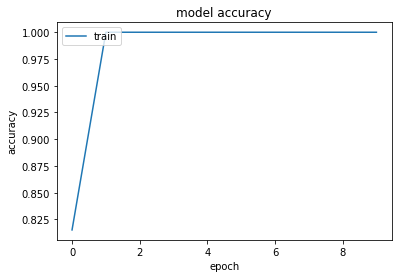

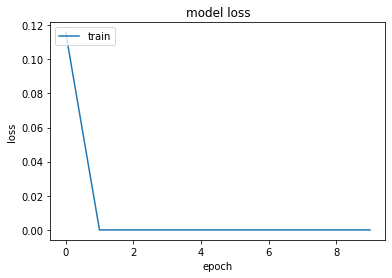

model.h5 has been saved.


In [6]:
if __name__ == "__main__":
    x, y = read_directory([richwater_path, broken_path])
    
    x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=21)

    run_model(x_train, y_train, x_test, y_test)

Train on 351 samples
Epoch 1/10
351/351 [==============================] - 28s 80ms/sample - loss: 0.2792 - accuracy: 0.4530
Epoch 2/10
351/351 [==============================] - 21s 61ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
351/351 [==============================] - 21s 61ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
351/351 [==============================] - 21s 61ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
351/351 [==============================] - 21s 60ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
351/351 [==============================] - 22s 61ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
351/351 [==============================] - 22s 62ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
351/351 [==============================] - 21s 60ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
351/351 [==============================] - 21s 61ms/sample - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10

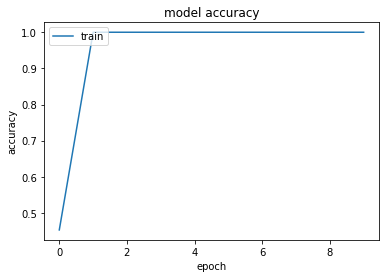

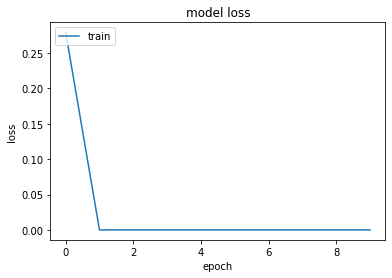

model.h5 has been saved.


In [18]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.1)

run_model(x_train, y_train, x_test, y_test)

In [24]:
pd.DataFrame(x[0]).T.values.tolist()

[[256.0,
  2.2403476496790595e-14,
  1.7005586010706614e-14,
  1.4925207190452622e-14,
  2.0716767280201212e-15,
  4.595502575374648e-14,
  4.963330525806172e-15,
  1.3220492124606344e-14,
  3.383302728906725e-14,
  3.337067093876852e-14,
  1.8919692619462932e-14,
  2.4221879478040582e-14,
  6.391504432736771e-14,
  3.352261701290863e-14,
  4.853323986055492e-14,
  6.915633555450783e-14,
  1.0791396413373074e-13,
  1.0476849433521377e-13,
  1.0162208522161897e-13,
  8.842768672661117e-14,
  1.1375828345602459e-13,
  9.937654562552934e-14,
  1.009853848359671e-13,
  1.013736444382089e-13,
  1.0489303522952712e-13,
  8.558953215697856e-14,
  9.692454477580987e-14,
  9.101945022628205e-14,
  9.40543179780221e-14,
  8.856696597084596e-14,
  9.001193288872652e-14,
  8.189837014279008e-14,
  8.105332824600673e-14,
  7.681086144500937e-14,
  7.746627753761553e-14,
  7.474843542670458e-14,
  6.872201046454836e-14,
  6.642794205118613e-14,
  7.143800503333223e-14,
  6.586528929281185e-14,
  7.0